In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37399")
client

<Client: 'tcp://127.0.0.1:37399' processes=6 threads=24, memory=46.81 GiB>

In [1]:
# For local computation

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

In [1]:
import sys, os
sys.path.insert(1, '/nfs/cms/martialc/DTUpgrade/src')

In [2]:
import dtupy_analysis
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyarrow as pa
import pyarrow.parquet as pq
import dask

In [9]:
file = '/nfs/cms/martialc/DTUpgrade/data/sxa5_240802_full.parquet'
ddf : dd.DataFrame = dd.read_parquet(file,
                    # dtype_backend       = "pyarrow" ,
                    # filesystem          = 'arrow'   ,
                    split_row_groups    =  True     ,
                )\
                # .astype({
                #     'channel'   : 'uint8',    # CHANNEL
                #     'bx'        : 'uint16',   # BX
                #     'tdc'       : 'uint8',    # TDC
                #     'link'      : 'uint8',     # LINK
                #     'index_t'   : 'uint64' ,
                #     'obdt_type' : 'uint8'  ,
                #     'obdt_ctr'  : 'uint8'  ,
                #     'station'   : 'int8'   ,
                #     'sl'        : 'uint8'  ,
                #     'layer'     : 'uint8'  ,
                #     'cell'      : 'uint8'  ,
                # })
ddf

,bx,cell,channel,index_t,layer,link,obdt_ctr,obdt_type,sl,station,tdc
npartitions=125,,,,,,,,,,,
,uint16,uint8,uint8,uint64,uint8,uint8,uint8,uint8,uint8,int8,uint8
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [6]:
layers = ddf.layer.unique().compute()
st = 1
sl = 1
ddf_sl = ddf[(ddf.station==st) & (ddf.sl == sl)].partitions[0].drop(columns=['station', 'sl'])
eps = 1e-6
# @dask.delayed
def matrix_diff(ddf, l_i, l_j, col, f = None):
    ddf_j = da.reshape(ddf[ddf.layer == l_j][col].to_dask_array(lengths=True), (-1,1))
    ddf_i = da.reshape(ddf[ddf.layer == l_i][col].to_dask_array(lengths=True), (1,-1))

    if f:
        ddf_i = f(ddf_i)
        ddf_j = f(ddf_j)
    
    return ddf_j - ddf_i

def normalize(mat):
    return (mat-mat.min())/(mat.max()-mat.min())


for layer_i, layer_j in zip(layers[:-1],layers[1:]):
    # layer_j > layer_i

    # Distance in time
    d_bx   = matrix_diff(ddf_sl, layer_i, layer_j, 'bx') # "This should be 0", come hits may come from a previous orbit, so not always true 
    d_tdc  = matrix_diff(ddf_sl, layer_i, layer_j, 'tdc')
    d_tdct = da.abs(32*d_bx + d_tdc) % (32*3556) 

    # Pseudo-distance in time
    d_idx  = da.abs(matrix_diff(ddf_sl, layer_i, layer_j, 'index_t', f = da.log10))
    
    # Distance in space
    d_cell = da.abs(matrix_diff(ddf_sl, layer_i, layer_j, 'cell'))
    
    # Now, this needs correcting the staggering.
    # For (1,2) and (3,4) we need to add 0.5 to the difference, for (2,3) we need to substract 0.5
    if layer_j % 2 == 0:
        d_cell += 0.5
    else:
        d_cell -= 0.5

    # Mask with only the real possible combinations
    mask = (d_tdct < 512) & (d_cell < 1)
    d_total = (d_cell + d_tdct + d_idx)
    d_total = da.where(mask, d_total, np.inf)
    # d_total = da.abs(d_idx) + da.where(da.abs(d_cell) <= 1, 0, np.inf) + da.where(da.abs(d_tdct) > 32*16, da.abs(d_tdct), np.inf)
    d_total = d_total.rechunk(1000,1000)
    break

In [7]:
def get_pairs(ddf, is_cont):
    is_cont = np.c_[da.where(is_cont)].tolist()
    is_cont = set(tuple(p) for p in is_cont)
    
    col_min  = da.stack([ddf.argmin(axis=0), da.arange(ddf.shape[1])]).T # min for each col
    col_min  = set(map(tuple, col_min.compute()))
    cont_col = col_min.intersection(is_cont)
    
    row_min  = da.stack([da.arange(ddf.shape[0]), ddf.argmin(axis=1)]).T # min for each row
    row_min  = set(map(tuple, row_min.compute()))
    cont_row = row_min.intersection(is_cont)

    
    pairs    = cont_col.intersection(cont_row)
    
    return pairs, (row_min, col_min)

In [ ]:
def plot_distance(d_total, d_cell = None, d_tdct = None, d_idx = None):
    fig, axes = plt.subplots(2,3, figsize = (10,6), sharex=True, sharey=True)

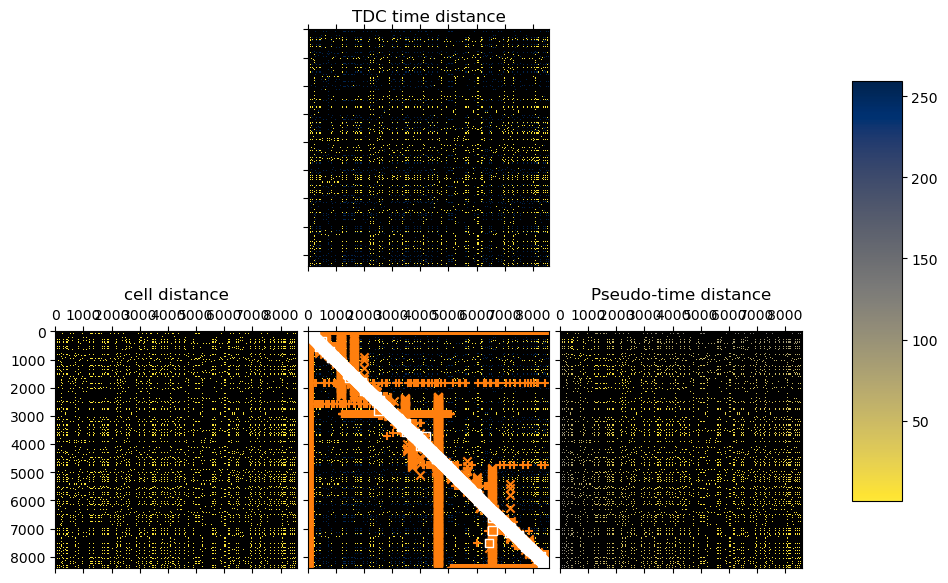

In [8]:
size = 1000

slices = np.arange(0,10000,size)
for i, f in zip(slices[:-1],slices[1:]):
    i,f = 0, -1
    fig, axes = plt.subplots(2,3, figsize = (10,6), sharex=True, sharey=True)
    [ax.axis('off') for ax in axes.ravel()]
    
    cm = mpl.colormaps.get_cmap('cividis_r')
    cm.set_bad('k')
    
    #time dist
    ax = axes[0,1]
    ax.set_title('TDC time distance')
    ax.axis('on')
    d_tdct = da.where(mask, d_tdct, np.inf)
    d_tdct = d_tdct.rechunk(1000,1000)
    ax.matshow(d_tdct[i:f,i:f].compute(),cmap=cm)

    #cell dist
    ax = axes[1,0]
    ax.set_title('cell distance')
    ax.axis('on')
    d_cell = da.where(mask, d_cell, np.inf)
    d_cell = d_cell.rechunk(1000,1000)
    ax.matshow(d_cell[i:f,i:f].compute(),cmap=cm)

    #idx dist
    ax = axes[1,2]
    ax.axis('on')
    ax.set_title('Pseudo-time distance')
    d_idx = da.where(mask, d_idx, np.inf)
    d_idx = d_idx.rechunk(1000,1000)
    ax.matshow(d_idx[i:f,i:f].compute(),cmap=cm)

    # Total dist
    ax = axes[1,1]
    ax.axis('on')
    pcm = ax.matshow(d_total[i:f,i:f].compute(),cmap=cm)
    pairs, (row_min, col_min) = get_pairs(d_total[i:f,i:f], (d_cell < 1))
    if len(pairs) > 0:

        x, y = np.array([list(row) for row in row_min]).T[::-1]
        ax.scatter(x, y,
                   marker = 'x',
                   color='C1'
                )
        
        x, y = np.array([list(col) for col in col_min]).T[::-1]
        ax.scatter(x, y,
                   marker = '+',
                   color='C1'
                )
        x, y = np.array([list(pair) for pair in pairs]).T[::-1]
        ax.scatter(x, y,
                   marker = 's',
                   facecolor='none',
                   edgecolor='w'
                )
    
    #color bar
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(pcm, cax=cbar_ax)
    plt.show()
    break


    


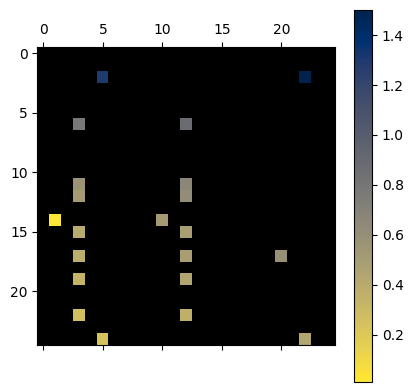

In [90]:
artist = plt.matshow(d_idx[:25,:25], cmap = cm)
plt.colorbar(artist, ax=plt.gca())